# Microsoft Original Content Insight Project
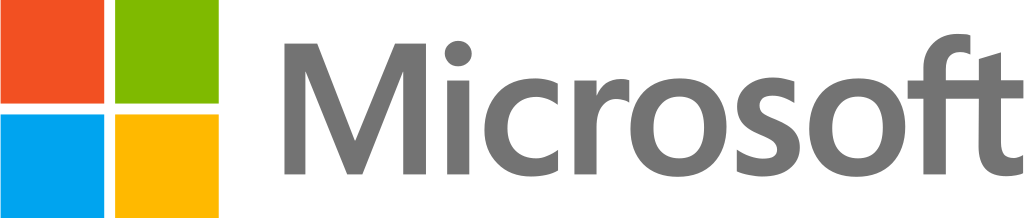

## Overview

This project analyzes the movie data from ***IMDB*** and ***The Numbers*** to help guide Micrsofts direction in the original content market.  Analysis of production budget and worldwide gross varies greatly across movie genres and Microsoft can use this data to make a more informed decision.  

## Business Problem

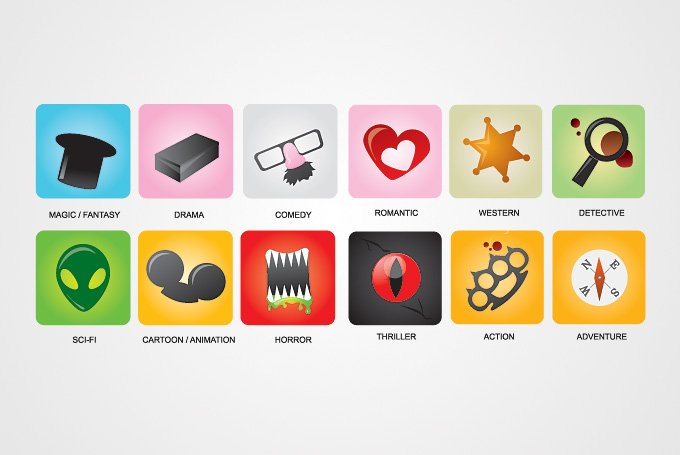

With so many genres of film, it can be hard to determine where to start.  Narrowing done these genres based on key variables will help mitigate some of the risks Microsoft faces in this new market for them.  Using production budget, worldwide gross, and genre statistics to predict the best possible genres for their first original content.

## Data Understanding

***IMDB*** provides us with an extensive database of movie information.  Here you can find everything from actors and director to release dates and runtime.  For this analysis we will focus on movie title, release year, and genres.  We will also use information from ***The Number***.  Here we once again from the movie title and release date, but we also find the production budget and gross infromation.

In [1]:
import sqlite3 #
from zipfile import ZipFile #
import pandas as pd #
import os #
import csv #
import datetime #
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates
import seaborn as sns
import numpy as np
from math import sqrt

%matplotlib inline



## Reading the Data

*

*

*

*

*

### IMDB

In [2]:
with ZipFile('Data/im.db.zip', 'r') as zip:
    zip.extractall()

In [3]:
sqliteConnection = sqlite3.connect('im.db')

In [4]:
sql_query = """SELECT name FROM sqlite_master  
  WHERE type='table';"""

In [5]:
cursor = sqliteConnection.cursor()

In [6]:
cursor.execute(sql_query)

In [7]:
print(cursor.fetchall())

[('movie_basics',), ('directors',), ('known_for',), ('movie_akas',), ('movie_ratings',), ('persons',), ('principals',), ('writers',)]


From these tabels, I want to take a look at `movie_basics` and `movie_akas` to see if they have information that is useful to my analysis.

#### IMDB Movie Basics

In [8]:
imdb_basics = pd.read_sql("""
SELECT *
  FROM movie_basics;
""", sqliteConnection)

imdb_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [9]:
imdb_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


#### IMDB Movie AKAs

In [10]:
imdb_akas = pd.read_sql("""
SELECT *
  FROM movie_akas;
""", sqliteConnection)

imdb_akas.head()

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.0


In [11]:
os.remove('im.db')

### Bom Movie Gross

In [12]:
# Connect to Bom Movie Gross csv file
bom_movie_gross = pd.read_csv('data/bom.movie_gross.csv')

In [13]:
# Visualize is data to get an idea of what is contains
bom_movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [14]:
bom_movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


### The Numbers

In [15]:
# Connect to Bom Movie Gross csv file
tn_movie_budget = pd.read_csv('data/tn.movie_budgets.csv')

In [16]:
# Visualize is data to get an idea of what is contains
tn_movie_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [17]:
tn_movie_budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


Since it looks like there is no missing data, let's see if there is duplicate information.

In [18]:
tn_movie_budget.duplicated().values.any()

False

There is also no duplicate data.  This looks like the best options for our budget information.

## Cleaning the Data
*

*

*

*

*

*

*

### IMDB Movie Basics
This dataframe has for both merging the dataframes (`release year` and `movie`) as well as important information for the analysis (`production_budget`, `domestic_gross`, and `worldwide_gross`).  Let start by seeing what kind of information it contains using `.info`.

In [19]:
# Let me see what kind of data we have.
imdb_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


We can see that we have some missing values.

In [20]:
# This will tell me how many null values we have and where they are.
imdb_basics.isnull().sum()

movie_id               0
primary_title          0
original_title        21
start_year             0
runtime_minutes    31739
genres              5408
dtype: int64

Let's remove `original_title` since it is redundant.

In [21]:
# Removes the original_title column
imdb_basics = imdb_basics.drop('original_title', 1)

In [22]:
# This allows me to visually confirm the column was removed
imdb_basics.head()

,movie_id,primary_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy"


Next, let's review `runtime_minutes`.  What percentage of data are we dealing with.

In [23]:
# I wrote a function to give me the missing percentage for
# a given column in a dataframe.
def miss_perc(column):
    perc = (column.isnull().sum() / len(column))*100
    print('There is {}% missing data'.format(round(perc, 2)))

In [24]:
# Run the function to see percentage of missing data from genres.
miss_perc(imdb_basics['genres'])

There is 3.7% missing data


3.7% is a relative small amount.  Lets remove those rows.

In [25]:
imdb_basics = imdb_basics.dropna(subset=['genres'])

In [26]:
# Let's see if it worked
imdb_basics.isnull().sum()

movie_id               0
primary_title          0
start_year             0
runtime_minutes    28503
genres                 0
dtype: int64

Now let's move onto `runtime_minutes`.

In [27]:
# Run the function to see percentage of missing data from genres.
miss_perc(imdb_basics['runtime_minutes'])

There is 20.25% missing data


20.25% is too large to just delete. Let review the `mean` and `median` data to see which would be best to replace the null values.

In [28]:
# Check the mean value for runtime.
imdb_basics['runtime_minutes'].mean()

86.26190157974928

In [29]:
# Check the mean value for runtime.
imdb_basics['runtime_minutes'].median()

87.0

Since they are both so close, we could use either.  Let's go with `median` to keep the data cleaner.

In [30]:
# Replace all missing data in runtime with median value.
imdb_basics.fillna(value=87, inplace=True)

In [31]:
# Let's see if it worked
imdb_basics.isnull().sum()

movie_id           0
primary_title      0
start_year         0
runtime_minutes    0
genres             0
dtype: int64

Let's see if we have any duplicate data.

In [32]:
imdb_basics.duplicated().values.any()

False

Now that we know that there is no duplicate data, we can move on.

Next, let's rename `primary_title` to `movie` to be more consistant across all the dataframes. We'll also change the index to `movie` for easier merging later.

In [33]:
# Changes the column name from 'primary_title' to 'movie'.
imdb_basics.rename(columns={'primary_title':'movie'}, inplace=True)

# Changes the index from 'movie_id' to 'movie'.
imdb_basics.set_index('movie', inplace=True)

imdb_basics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140736 entries, Sunghursh to Chico Albuquerque - Revelações
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         140736 non-null  object 
 1   start_year       140736 non-null  int64  
 2   runtime_minutes  140736 non-null  float64
 3   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 5.4+ MB


Now that we no longer need it, let's remove column `movie_id`.

In [34]:
# Removes column 'movie_id'.
imdb_basics = imdb_basics.drop('movie_id', 1)

# Let's view the dataframe to make sure we have it the way we want.
imdb_basics.head()

,start_year,runtime_minutes,genres
movie,,,
Sunghursh,2013,175.0,"Action,Crime,Drama"
One Day Before the Rainy Season,2019,114.0,"Biography,Drama"
The Other Side of the Wind,2018,122.0,Drama
Sabse Bada Sukh,2018,87.0,"Comedy,Drama"
The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy"


### The Numbers budget data

In [35]:
# Let's see what kind of data we have.
tn_movie_budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [36]:
# View how much data we have missing.
tn_movie_budget.isnull().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

No missing data.  Let's see if we have any duplicates.

In [37]:
tn_movie_budget.duplicated().values.any()

False

In [38]:
# Visualize the data
tn_movie_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


We know that `production_budget`, `domestic_gross`, and `worldwide_gross` are `strings` and we need them to be `integers`. Let's start by removing the '$' and ','.

In [39]:
# Removes the $ and, from all three columns.
tn_movie_budget['production_budget'] = tn_movie_budget['production_budget'].replace('[$,]','', regex=True)
tn_movie_budget['domestic_gross'] = tn_movie_budget['domestic_gross'].replace('[$,]','', regex=True)
tn_movie_budget['worldwide_gross']=tn_movie_budget['worldwide_gross'].replace('[$,]','', regex=True)

# Visually check to see if it worked.
tn_movie_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747


Stripping the the string worked, but they are still strings as you can see below.

In [40]:
tn_movie_budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


Use `pd.to_numeric` to convert each of these columns to intergers.

In [41]:
# Converts production budget from string to integer
tn_movie_budget['production_budget'] = pd.to_numeric(tn_movie_budget['production_budget'])

In [42]:
# Converts domestic gross from string to integer
tn_movie_budget['domestic_gross'] = pd.to_numeric(tn_movie_budget['domestic_gross'])

In [43]:
# Converts worldwide gross from string to integer
tn_movie_budget['worldwide_gross'] = pd.to_numeric(tn_movie_budget['worldwide_gross'])

Let's make sure it worked.

In [44]:
# Let's me see that the strings were changed to integers.
tn_movie_budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   int64 
 4   domestic_gross     5782 non-null   int64 
 5   worldwide_gross    5782 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 271.2+ KB


The `imdb_basics` dataframe uses `start_year`.  Let me pull the year out of the `release_date` and make it it's own column.  This will help when we merge later.

In [45]:
# Converts release_date to datetime and creates a new column with just the year.
tn_movie_budget['year'] = pd.DatetimeIndex(tn_movie_budget['release_date']).year

# Visually check to see if it worked.
tn_movie_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2009
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,2019
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,2015
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017


Let's set the `index` to `movie` just like we did with the IMDB database.

In [46]:
# Changes the index from 'movie_id' to 'movie'.
tn_movie_budget.set_index('movie', inplace=True)

tn_movie_budget.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5782 entries, Avatar to My Date With Drew
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   production_budget  5782 non-null   int64 
 3   domestic_gross     5782 non-null   int64 
 4   worldwide_gross    5782 non-null   int64 
 5   year               5782 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 316.2+ KB


Now that we no longer need the `id` column, let's remove it.

In [47]:
# Removes the id column
tn_movie_budget = tn_movie_budget.drop('id', 1)

# Let's view the dataframe to make sure we have it the way we want.
tn_movie_budget.head()

,release_date,production_budget,domestic_gross,worldwide_gross,year
movie,,,,,
Avatar,"Dec 18, 2009",425000000,760507625,2776345279,2009
Pirates of the Caribbean: On Stranger Tides,"May 20, 2011",410600000,241063875,1045663875,2011
Dark Phoenix,"Jun 7, 2019",350000000,42762350,149762350,2019
Avengers: Age of Ultron,"May 1, 2015",330600000,459005868,1403013963,2015
Star Wars Ep. VIII: The Last Jedi,"Dec 15, 2017",317000000,620181382,1316721747,2017


Let convert `release_date` from a string to datetime using `pd.to_datetime()`.  This will name it easier to analyze the data laters.

In [48]:
# Converts date from string to datetime.
tn_movie_budget['release_date'] = pd.to_datetime(tn_movie_budget['release_date'])

# Let's see if it works.
tn_movie_budget.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5782 entries, Avatar to My Date With Drew
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       5782 non-null   datetime64[ns]
 1   production_budget  5782 non-null   int64         
 2   domestic_gross     5782 non-null   int64         
 3   worldwide_gross    5782 non-null   int64         
 4   year               5782 non-null   int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 271.0+ KB


Now that we have both dataframes like we want them, merge them using `.merge()`.  We will use `movie` and `year` to merge the data.  This will insure that we don't merge movies with the same titles.

In [49]:
# Combines the IMDB table with The Numbers budget information
# along movie and year.
movies_df = pd.merge(imdb_basics, tn_movie_budget, left_on=['movie', 'start_year'], right_on=['movie', 'year'])
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1541 entries, Foodfight! to Unplanned
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   start_year         1541 non-null   int64         
 1   runtime_minutes    1541 non-null   float64       
 2   genres             1541 non-null   object        
 3   release_date       1541 non-null   datetime64[ns]
 4   production_budget  1541 non-null   int64         
 5   domestic_gross     1541 non-null   int64         
 6   worldwide_gross    1541 non-null   int64         
 7   year               1541 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 108.4+ KB


Everything looks good.

In [50]:
# Visualize the data
movies_df.head(25)

,start_year,runtime_minutes,genres,release_date,production_budget,domestic_gross,worldwide_gross,year
movie,,,,,,,,
Foodfight!,2012,91.0,"Action,Animation,Comedy",2012-12-31,45000000,0,73706,2012
The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",2013-12-25,91000000,58236838,187861183,2013
A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",2014-09-19,28000000,26017685,62108587,2014
Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",2015-06-12,215000000,652270625,1648854864,2015
The Rum Diary,2011,119.0,"Comedy,Drama",2011-10-28,45000000,13109815,21544732,2011
The Three Stooges,2012,92.0,"Comedy,Family",2012-04-13,30000000,44338224,54052249,2012
Anderson's Cross,2010,98.0,"Comedy,Drama,Romance",2010-12-31,300000,0,0,2010
Tangled,2010,100.0,"Adventure,Animation,Comedy",2010-11-24,260000000,200821936,586477240,2010
John Carter,2012,132.0,"Action,Adventure,Sci-Fi",2012-03-09,275000000,73058679,282778100,2012


## Analysis

### What trends can we find in the top 100 grossing films?

Let's start by finding the top 100 movies.  We can use `.sort_values()` along `worldwide_gross` and set that as a new dataframe.

In [51]:
# Sorts values in decending order and limits it to the first 100.
top_100_movies = movies_df.sort_values(['worldwide_gross'], ascending=False)[0:100]

top_100_movies

,start_year,runtime_minutes,genres,release_date,production_budget,domestic_gross,worldwide_gross,year
movie,,,,,,,,
Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",2018-04-27,300000000,678815482,2048134200,2018
Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",2015-06-12,215000000,652270625,1648854864,2015
Furious 7,2015,137.0,"Action,Crime,Thriller",2015-04-03,190000000,353007020,1518722794,2015
The Avengers,2012,143.0,"Action,Adventure,Sci-Fi",2012-05-04,225000000,623279547,1517935897,2012
Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi",2015-05-01,330600000,459005868,1403013963,2015
...,...,...,...,...,...,...,...,...
Kong: Skull Island,2017,118.0,"Action,Adventure,Fantasy",2017-03-10,185000000,168052812,561072059,2017
Cars 2,2011,106.0,"Adventure,Animation,Comedy",2011-06-24,200000000,191450875,560155383,2011
Ted,2012,106.0,"Comedy,Fantasy",2012-06-29,50000000,218665740,556016627,2012


We can delete the two redundant year columns.

In [52]:
# Removes 'start_year' 
top_100_movies = top_100_movies.drop('start_year', 1)

# Removes year
top_100_movies = top_100_movies.drop('year', 1)

Let's see if it worked.

In [53]:
top_100_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, Avengers: Infinity War to Brave
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   runtime_minutes    100 non-null    float64       
 1   genres             100 non-null    object        
 2   release_date       100 non-null    datetime64[ns]
 3   production_budget  100 non-null    int64         
 4   domestic_gross     100 non-null    int64         
 5   worldwide_gross    100 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 5.5+ KB


### 1) Genres

#### What trends are present among the top movie genres?

Let's start by breaking down the `genres` and then we can compare the to our `budget` and `gross` data.

First we need to split the string of data in `genres` into a list. We can do this by using the `lambda` function to `.apply()` a `.split()` at the commas.

In [54]:
# Split the genre data at the commas.
top_100_movies['genres'] = top_100_movies['genres'].apply(lambda x: x.split(",") if x else x)

# Let's see if it worked
top_100_movies

,runtime_minutes,genres,release_date,production_budget,domestic_gross,worldwide_gross
movie,,,,,,
Avengers: Infinity War,149.0,"[Action, Adventure, Sci-Fi]",2018-04-27,300000000,678815482,2048134200
Jurassic World,124.0,"[Action, Adventure, Sci-Fi]",2015-06-12,215000000,652270625,1648854864
Furious 7,137.0,"[Action, Crime, Thriller]",2015-04-03,190000000,353007020,1518722794
The Avengers,143.0,"[Action, Adventure, Sci-Fi]",2012-05-04,225000000,623279547,1517935897
Avengers: Age of Ultron,141.0,"[Action, Adventure, Sci-Fi]",2015-05-01,330600000,459005868,1403013963
...,...,...,...,...,...,...
Kong: Skull Island,118.0,"[Action, Adventure, Fantasy]",2017-03-10,185000000,168052812,561072059
Cars 2,106.0,"[Adventure, Animation, Comedy]",2011-06-24,200000000,191450875,560155383
Ted,106.0,"[Comedy, Fantasy]",2012-06-29,50000000,218665740,556016627


Now that we have the `genres` seperated out into a list, let's make a set of all the unique genres.


In [55]:
# Iterate through the rows of data and put each
# unique genre into a new set.

all_genres = []

for genre in top_100_movies['genres']:
    for x in genre:
        if x not in all_genres:
            all_genres.append(x)
            
# Let's see if it worked
all_genres

['Action',
 'Adventure',
 'Sci-Fi',
 'Crime',
 'Thriller',
 'Animation',
 'Comedy',
 'Family',
 'Fantasy',
 'Musical',
 'Drama',
 'Biography',
 'Music',
 'Horror',
 'Mystery',
 'Romance']

Now that we have each individual `genre`, let's see how many we have.

In [56]:
# Shows the length of all_genres
len(all_genres)

16

Lets add a column for each movie genre.  This will make it easier to analyze the data based on genre. 

In [57]:
# This iterates through all_genres and creates a column
# named after that genre.
for genre in all_genres:
    # Set the values to 0
    top_100_movies[genre] = 0
    
# Let's see if it works
top_100_movies

,runtime_minutes,genres,release_date,production_budget,domestic_gross,worldwide_gross,Action,Adventure,Sci-Fi,Crime,...,Comedy,Family,Fantasy,Musical,Drama,Biography,Music,Horror,Mystery,Romance
movie,,,,,,,,,,,,,,,,,,,,,
Avengers: Infinity War,149.0,"[Action, Adventure, Sci-Fi]",2018-04-27,300000000,678815482,2048134200,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Jurassic World,124.0,"[Action, Adventure, Sci-Fi]",2015-06-12,215000000,652270625,1648854864,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Furious 7,137.0,"[Action, Crime, Thriller]",2015-04-03,190000000,353007020,1518722794,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The Avengers,143.0,"[Action, Adventure, Sci-Fi]",2012-05-04,225000000,623279547,1517935897,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Avengers: Age of Ultron,141.0,"[Action, Adventure, Sci-Fi]",2015-05-01,330600000,459005868,1403013963,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kong: Skull Island,118.0,"[Action, Adventure, Fantasy]",2017-03-10,185000000,168052812,561072059,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cars 2,106.0,"[Adventure, Animation, Comedy]",2011-06-24,200000000,191450875,560155383,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ted,106.0,"[Comedy, Fantasy]",2012-06-29,50000000,218665740,556016627,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we need to iterate through the table again, this time if the genre is in the `genres` column for that movie, we will set the value equal to 1.

In [58]:
# This iterates through each row of data. For each genre
# in that row, is will set the matching column equal to 1.
for index, row in top_100_movies.iterrows():
    if row['genres']:
        for genre in row['genres']:
            top_100_movies.loc[index, genre] = 1
            
# Let's see if it workd
top_100_movies.head(10)

,runtime_minutes,genres,release_date,production_budget,domestic_gross,worldwide_gross,Action,Adventure,Sci-Fi,Crime,...,Comedy,Family,Fantasy,Musical,Drama,Biography,Music,Horror,Mystery,Romance
movie,,,,,,,,,,,,,,,,,,,,,
Avengers: Infinity War,149.0,"[Action, Adventure, Sci-Fi]",2018-04-27,300000000,678815482,2048134200,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
Jurassic World,124.0,"[Action, Adventure, Sci-Fi]",2015-06-12,215000000,652270625,1648854864,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
Furious 7,137.0,"[Action, Crime, Thriller]",2015-04-03,190000000,353007020,1518722794,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
The Avengers,143.0,"[Action, Adventure, Sci-Fi]",2012-05-04,225000000,623279547,1517935897,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
Avengers: Age of Ultron,141.0,"[Action, Adventure, Sci-Fi]",2015-05-01,330600000,459005868,1403013963,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
Black Panther,134.0,"[Action, Adventure, Sci-Fi]",2018-02-16,200000000,700059566,1348258224,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
Jurassic World: Fallen Kingdom,128.0,"[Action, Adventure, Sci-Fi]",2018-06-22,170000000,417719760,1305772799,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
Frozen,102.0,"[Adventure, Animation, Comedy]",2013-11-22,150000000,400738009,1272469910,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
Beauty and the Beast,129.0,"[Family, Fantasy, Musical]",2017-03-17,160000000,504014165,1259199706,0,0,0,0,...,0,1,1,1,0,0,0,0,0,0


It worked! Not we can see what genres make up the top 100 films.  Let's start by finding out how many films are in each genre.

First, we have to create an empty dictionary called `genre_count`. Then we can iterate through our list of `all_genres`.  Then we can use `.sum()` to find the sum of the movies for each genres.  Lastly, we add that genre, as a `.key`, to the `genre_count` and set its' `.value` to the sum of the column.

In [59]:
# Create an empty dictionary to store the genre and count
genre_count={}

# Iterrate through each genre in our all_genres list.
for column in all_genres:
    # Finds the column sum for each genre and stores
    # it in our genre_count dictionary.
    genre_count[column] = top_100_movies[column].sum()
    
genre_count

{'Action': 59,
 'Adventure': 86,
 'Sci-Fi': 31,
 'Crime': 3,
 'Thriller': 10,
 'Animation': 27,
 'Comedy': 31,
 'Family': 10,
 'Fantasy': 21,
 'Musical': 3,
 'Drama': 10,
 'Biography': 1,
 'Music': 1,
 'Horror': 3,
 'Mystery': 1,
 'Romance': 1}

Let's visualize this.

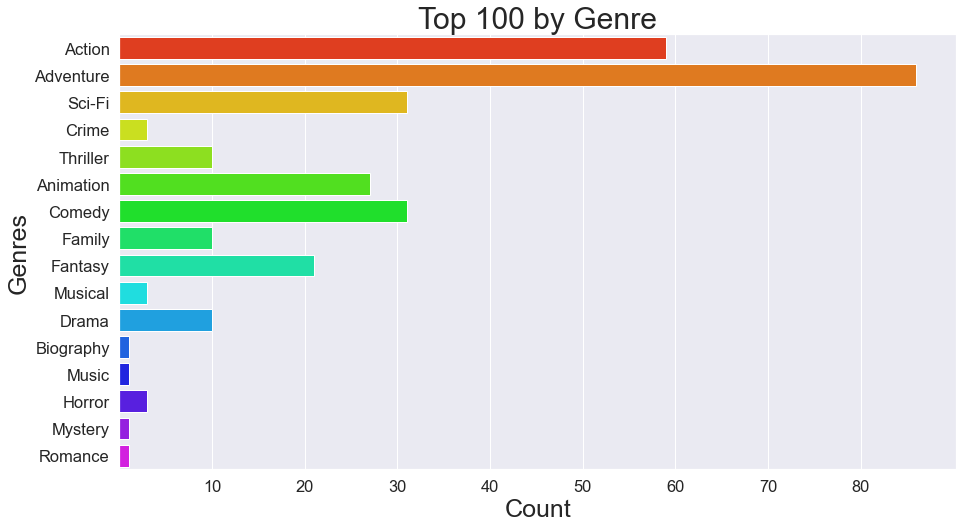

In [60]:
# Create a plot and set the size.
plt.figure(figsize=(15,8))

# Increase the size of the scale text.
sns.set(font_scale=1.5)

# Plot the data
sns.barplot(y=list(genre_count.keys()),
            x=list(genre_count.values()), palette='gist_rainbow')

# Set the barplot's title.
plt.title('Top 100 by Genre', fontsize=30)

# Label the y-axis
plt.ylabel('Genres', fontsize=25)

# Label the x-axis
plt.xlabel('Count', fontsize=25);

# Change the value of the x axis ticks
plt.xticks([10,20,30,40,50,60,70,80]);

We can see from the `barplot` that the ***Action*** and ***Adventure*** genres are by far the most popular.

Let's see how they compare to the rest of the genres in domestic gross.  We'll start with ***Adventure*** as it is the most popular.

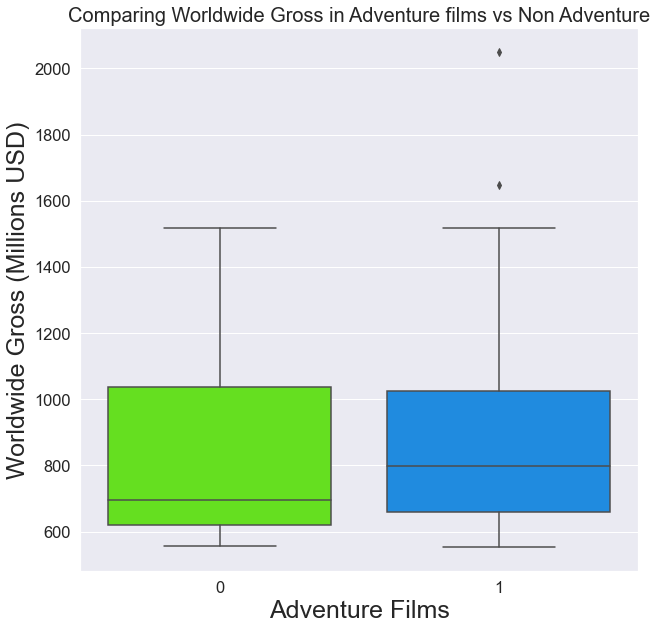

In [61]:
# Create a plot and set the size.
plt.figure(figsize=(10,10))

# Increase the size of the scale text.
sns.set(font_scale=1.5)

# Plot the data
sns.boxplot(x=top_100_movies['Adventure'],
            y=top_100_movies['worldwide_gross']/1000000, palette='gist_rainbow')

# Set the barplot's title.
plt.title('Comparing Worldwide Gross in Adventure films vs Non Adventure', fontsize=20)

# Label the y-axis
plt.ylabel('Worldwide Gross (Millions USD)', fontsize=25)

# Label the x-axis
plt.xlabel('Adventure Films', fontsize=25);

Here we can see that adventure films have a larger interquartile and min max range, this is do to the adventure category gave so many more films.  The median value seems to be ***60 Million** more than the non-adventure films.

Let's do the same comparison with the `production_budget`.

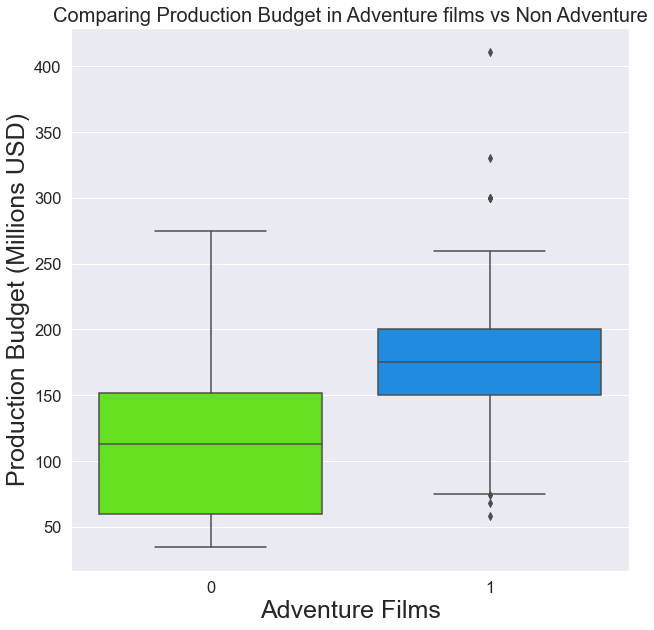

In [62]:
# Create a plot and set the size.
plt.figure(figsize=(10,10))

# Increase the size of the scale text.
sns.set(font_scale=1.5)

# Plot the data
sns.boxplot(x=top_100_movies['Adventure'],
            y=top_100_movies['production_budget']/1000000, palette='gist_rainbow')

# Set the barplot's title.
plt.title('Comparing Production Budget in Adventure films vs Non Adventure', fontsize=20)

# Label the y-axis
plt.ylabel('Production Budget (Millions USD)', fontsize=25)

# Label the x-axis
plt.xlabel('Adventure Films', fontsize=25);

Here we can see the median value for ***Production Budget*** is roughly ***$60 million*** higher in ***Adventure Films*** vs ***Non-Adventure Films***

Let's make the same comparisons for Action movies.

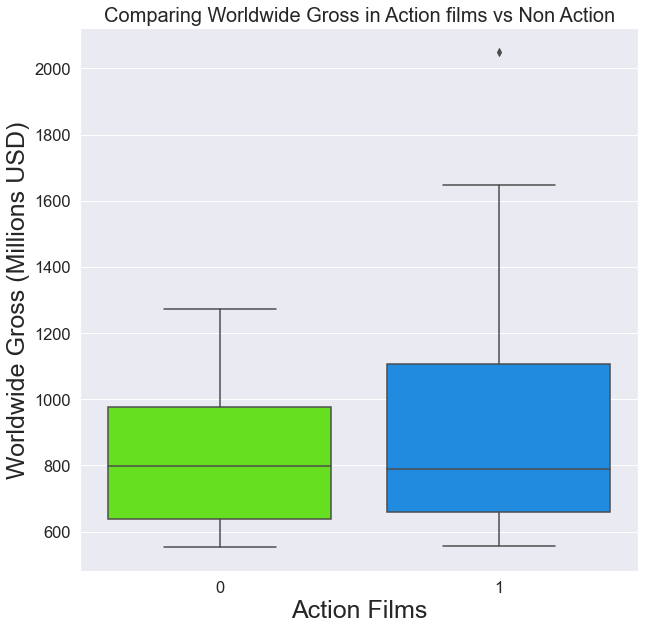

In [63]:
# Create a plot and set the size.
plt.figure(figsize=(10,10))

# Increase the size of the scale text.
sns.set(font_scale=1.5)

# Plot the data
sns.boxplot(x=top_100_movies['Action'],
            y=top_100_movies['worldwide_gross']/1000000, palette='gist_rainbow')

# Set the barplot's title.
plt.title('Comparing Worldwide Gross in Action films vs Non Action', fontsize=20)

# Label the y-axis
plt.ylabel('Worldwide Gross (Millions USD)', fontsize=25)

# Label the x-axis
plt.xlabel('Action Films', fontsize=25);

Here we see that median `worldwide_gross` in ***Action Films*** are almost identical to ***Non-Action Films***.  We do see a higher interquartile range and much higher maximum potential.

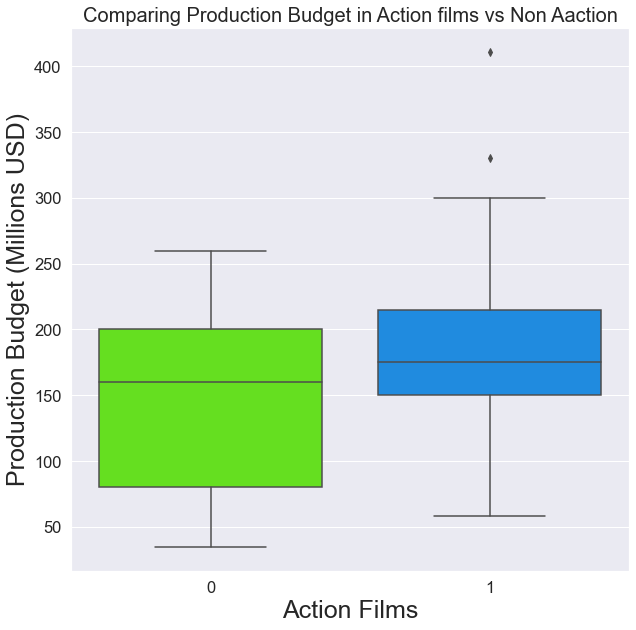

In [64]:
# Create a plot and set the size.
plt.figure(figsize=(10,10))

# Increase the size of the scale text.
sns.set(font_scale=1.5)

# Plot the data
sns.boxplot(x=top_100_movies['Action'],
            y=top_100_movies['production_budget']/1000000, palette='gist_rainbow')

# Set the barplot's title.
plt.title('Comparing Production Budget in Action films vs Non Aaction', fontsize=20)

# Label the y-axis
plt.ylabel('Production Budget (Millions USD)', fontsize=25)

# Label the x-axis
plt.xlabel('Action Films', fontsize=25);

Here we find that the ***Action Movie*** Production Budget align much better with the ***Non-Action Movies*** with only slight higher minimum and maximum values.

We can see that ***Action and Adventure Movies*** are higher grossing and have higher production budgets.  Let's see how that compare with `return_on_investment`.  For this calculation, we will subtract `production_budget` from `worldwide_gross` and set that value in a new column.

In [65]:
# Cycles through each row to calculate the Return on Investment
top_100_movies.loc[:,'return_on_investment'] = top_100_movies['worldwide_gross'] - top_100_movies['production_budget']

# Let's see if it worked
top_100_movies.head()

,runtime_minutes,genres,release_date,production_budget,domestic_gross,worldwide_gross,Action,Adventure,Sci-Fi,Crime,...,Family,Fantasy,Musical,Drama,Biography,Music,Horror,Mystery,Romance,return_on_investment
movie,,,,,,,,,,,,,,,,,,,,,
Avengers: Infinity War,149.0,"[Action, Adventure, Sci-Fi]",2018-04-27,300000000,678815482,2048134200,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1748134200
Jurassic World,124.0,"[Action, Adventure, Sci-Fi]",2015-06-12,215000000,652270625,1648854864,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1433854864
Furious 7,137.0,"[Action, Crime, Thriller]",2015-04-03,190000000,353007020,1518722794,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1328722794
The Avengers,143.0,"[Action, Adventure, Sci-Fi]",2012-05-04,225000000,623279547,1517935897,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1292935897
Avengers: Age of Ultron,141.0,"[Action, Adventure, Sci-Fi]",2015-05-01,330600000,459005868,1403013963,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1072413963


Let's compare the ***Adventure movies*** `return_on_investment` to ***Non-Adventure movies***

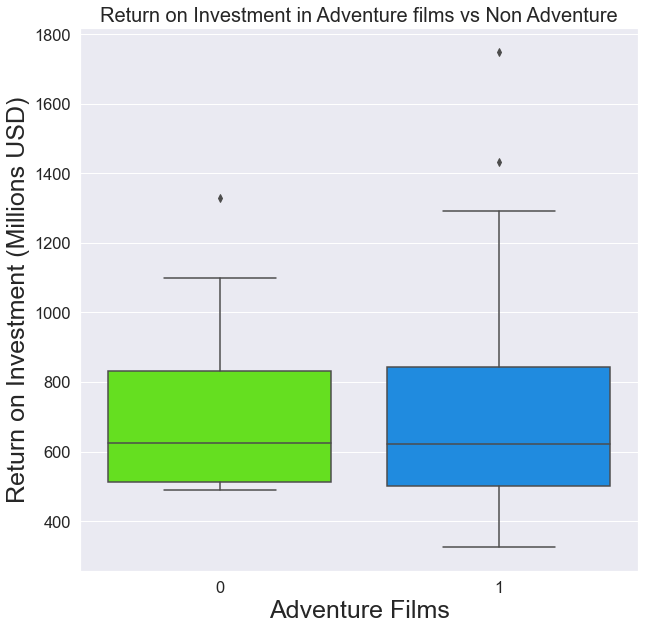

In [66]:
# Create a plot and set the size.
plt.figure(figsize=(10,10))

# Increase the size of the scale text.
sns.set(font_scale=1.5)

# Plot the data
sns.boxplot(x=top_100_movies['Adventure'],
            y=top_100_movies['return_on_investment']/1000000, palette='gist_rainbow')

# Set the barplot's title.
plt.title('Return on Investment in Adventure films vs Non Adventure', fontsize=20)

# Label the y-axis
plt.ylabel('Return on Investment (Millions USD)', fontsize=25)

# Label the x-axis
plt.xlabel('Adventure Films', fontsize=25);

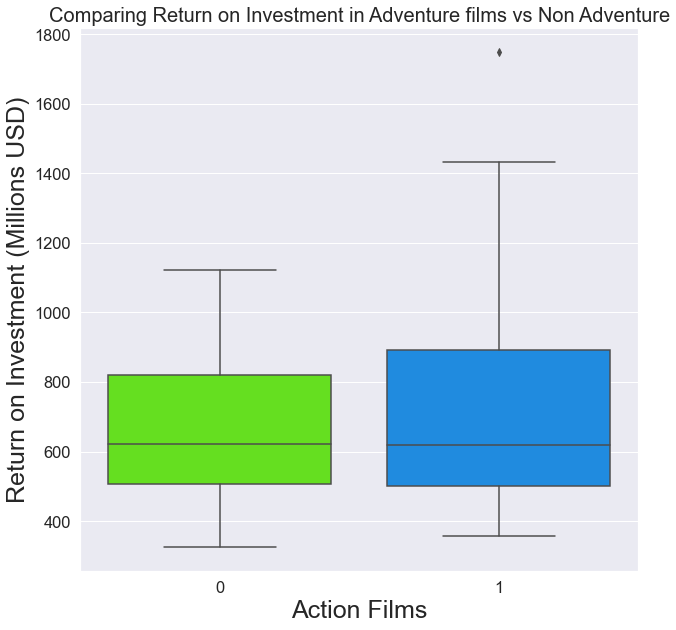

In [67]:
# Create a plot and set the size.
plt.figure(figsize=(10,10))

# Increase the size of the scale text.
sns.set(font_scale=1.5)

# Plot the data
sns.boxplot(x=top_100_movies['Action'],
            y=top_100_movies['return_on_investment']/1000000, palette='gist_rainbow')

# Set the barplot's title.
plt.title('Comparing Return on Investment in Adventure films vs Non Adventure', fontsize=20)

# Label the y-axis
plt.ylabel('Return on Investment (Millions USD)', fontsize=25)

# Label the x-axis
plt.xlabel('Action Films', fontsize=25);

We can see from the two `boxplot` that ***Action Movies*** and ***Adventure Movies*** have a similar `return_on_investment` to to their ***Non-Action and Adventure*** counterparts.  

We could see that many of the ***Action Genre*** movies also appeard in the ***Adventure Genre***.  Let's create another sub-category of `action_and_adventure` movies and see how the `return_on_investments` compare.

In [68]:
# Create a new column for Action and Adventure movies
top_100_movies['action_and_adventure']=0

# Iterrate through the rows
for index, row in top_100_movies.iterrows():
    # Checks to see if the film is both Action and Adventure
    if row['Action'] == 1 and row['Adventure'] == 1:
        # Set the Action and Adventure column equal to 1.
        top_100_movies.loc[index, 'action_and_adventure'] = 1

# Let's see if it works
top_100_movies.head()

,runtime_minutes,genres,release_date,production_budget,domestic_gross,worldwide_gross,Action,Adventure,Sci-Fi,Crime,...,Fantasy,Musical,Drama,Biography,Music,Horror,Mystery,Romance,return_on_investment,action_and_adventure
movie,,,,,,,,,,,,,,,,,,,,,
Avengers: Infinity War,149.0,"[Action, Adventure, Sci-Fi]",2018-04-27,300000000,678815482,2048134200,1,1,1,0,...,0,0,0,0,0,0,0,0,1748134200,1
Jurassic World,124.0,"[Action, Adventure, Sci-Fi]",2015-06-12,215000000,652270625,1648854864,1,1,1,0,...,0,0,0,0,0,0,0,0,1433854864,1
Furious 7,137.0,"[Action, Crime, Thriller]",2015-04-03,190000000,353007020,1518722794,1,0,0,1,...,0,0,0,0,0,0,0,0,1328722794,0
The Avengers,143.0,"[Action, Adventure, Sci-Fi]",2012-05-04,225000000,623279547,1517935897,1,1,1,0,...,0,0,0,0,0,0,0,0,1292935897,1
Avengers: Age of Ultron,141.0,"[Action, Adventure, Sci-Fi]",2015-05-01,330600000,459005868,1403013963,1,1,1,0,...,0,0,0,0,0,0,0,0,1072413963,1


Let's see home many films fit into the `action and adventure` category.

In [69]:
# Calculates and print total number of Action and Adventure films
print('There are {} films in the Action and Adventure category'.format(top_100_movies['action_and_adventure'].sum()))

There are 53 films in the Action and Adventure category


Just over half of the films in the ***Top 100*** fit in the ***Action and Adventure*** category.  Now let see how the `action_and_adventure` movies compare to their counterparts.

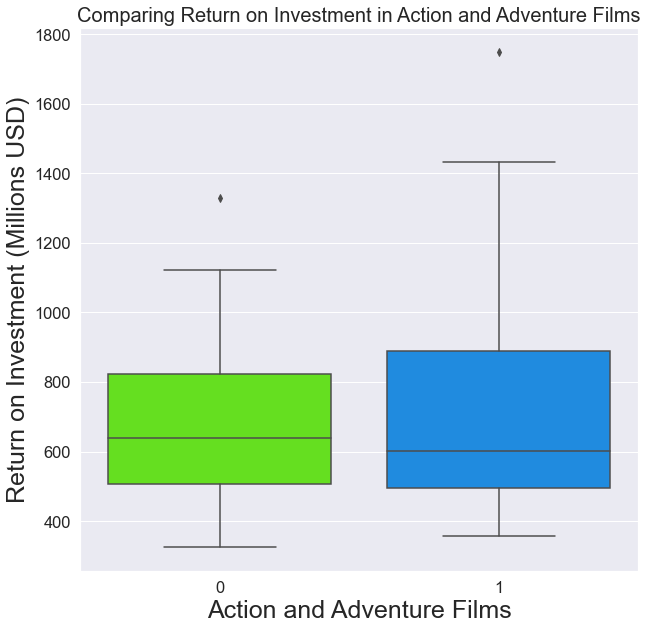

In [70]:
# Create a plot and set the size.
plt.figure(figsize=(10,10))

# Increase the size of the scale text.
sns.set(font_scale=1.5)

# Plot the data
sns.boxplot(x=top_100_movies['action_and_adventure'],
            y=top_100_movies['return_on_investment']/1000000, palette='gist_rainbow')

# Set the barplot's title.
plt.title('Comparing Return on Investment in Action and Adventure Films', fontsize=20)

# Label the y-axis
plt.ylabel('Return on Investment (Millions USD)', fontsize=25)

# Label the x-axis
plt.xlabel('Action and Adventure Films', fontsize=25);

While the `median` and inerquartile values are similar, the potential upside in the Action and Adventure movies is greater.  Here we see that a maximum range that is nearly ***$325 Million*** higher!

Most of the movies in the Action and Adventure category have a third subgenre associated with them.  What can we determine if we go deeper into this category?

#### Top genre summary

The ***Action*** and ***Adventure*** genres are the most popular among the top grossing films.  

***Actions films*** have a ***$50million*** higher interquartile range in worldwide gross and a ***$25 mil*** higher return on investment median.

***Adventure films*** have a similar interquartile range to non-adventure films in worldwide gross and return on investment.

#### What trends appear among the subgenres of Action/Adventure

Most ***Action*** or ***Adventure*** films have both genres as subgenres.  

In [71]:
# Create a new dataframe of just the movies that are action and adventure.
top_aa_movies = top_100_movies[(top_100_movies['action_and_adventure'] == 1)]

# Let's see if it worked.
top_aa_movies

,runtime_minutes,genres,release_date,production_budget,domestic_gross,worldwide_gross,Action,Adventure,Sci-Fi,Crime,...,Fantasy,Musical,Drama,Biography,Music,Horror,Mystery,Romance,return_on_investment,action_and_adventure
movie,,,,,,,,,,,,,,,,,,,,,
Avengers: Infinity War,149.0,"[Action, Adventure, Sci-Fi]",2018-04-27,300000000,678815482,2048134200,1,1,1,0,...,0,0,0,0,0,0,0,0,1748134200,1
Jurassic World,124.0,"[Action, Adventure, Sci-Fi]",2015-06-12,215000000,652270625,1648854864,1,1,1,0,...,0,0,0,0,0,0,0,0,1433854864,1
The Avengers,143.0,"[Action, Adventure, Sci-Fi]",2012-05-04,225000000,623279547,1517935897,1,1,1,0,...,0,0,0,0,0,0,0,0,1292935897,1
Avengers: Age of Ultron,141.0,"[Action, Adventure, Sci-Fi]",2015-05-01,330600000,459005868,1403013963,1,1,1,0,...,0,0,0,0,0,0,0,0,1072413963,1
Black Panther,134.0,"[Action, Adventure, Sci-Fi]",2018-02-16,200000000,700059566,1348258224,1,1,1,0,...,0,0,0,0,0,0,0,0,1148258224,1
Jurassic World: Fallen Kingdom,128.0,"[Action, Adventure, Sci-Fi]",2018-06-22,170000000,417719760,1305772799,1,1,1,0,...,0,0,0,0,0,0,0,0,1135772799,1
Incredibles 2,118.0,"[Action, Adventure, Animation]",2018-06-15,200000000,608581744,1242520711,1,1,0,0,...,0,0,0,0,0,0,0,0,1042520711,1
Iron Man 3,130.0,"[Action, Adventure, Sci-Fi]",2013-05-03,200000000,408992272,1215392272,1,1,1,0,...,0,0,0,0,0,0,0,0,1015392272,1
Aquaman,143.0,"[Action, Adventure, Fantasy]",2018-12-21,160000000,335061807,1146894640,1,1,0,0,...,1,0,0,0,0,0,0,0,986894640,1


Now let's get rid of the columns we no longer need.

In [72]:
# Drop the Action column
top_aa_movies = top_aa_movies.drop('Action', 1)

# Drop the Adventure column
top_aa_movies = top_aa_movies.drop('Adventure', 1)

# Drop the Action and Adventure column
top_aa_movies = top_aa_movies.drop('action_and_adventure', 1)

# Let's see if it worked
top_aa_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53 entries, Avengers: Infinity War to Puss in Boots
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   runtime_minutes       53 non-null     float64       
 1   genres                53 non-null     object        
 2   release_date          53 non-null     datetime64[ns]
 3   production_budget     53 non-null     int64         
 4   domestic_gross        53 non-null     int64         
 5   worldwide_gross       53 non-null     int64         
 6   Sci-Fi                53 non-null     int64         
 7   Crime                 53 non-null     int64         
 8   Thriller              53 non-null     int64         
 9   Animation             53 non-null     int64         
 10  Comedy                53 non-null     int64         
 11  Family                53 non-null     int64         
 12  Fantasy               53 non-null     int64         


In [73]:
# Iterrate throught the row in top_aa_movies
for index, row in top_aa_movies.iterrows():
    # Iterrate through the three genres in that row
    for genre in row['genres']:
        # Replace the value with last genre of the three
        top_aa_movies.loc[index, 'genres'] = genre

#Let's see if it worked
top_aa_movies

,runtime_minutes,genres,release_date,production_budget,domestic_gross,worldwide_gross,Sci-Fi,Crime,Thriller,Animation,...,Family,Fantasy,Musical,Drama,Biography,Music,Horror,Mystery,Romance,return_on_investment
movie,,,,,,,,,,,,,,,,,,,,,
Avengers: Infinity War,149.0,Sci-Fi,2018-04-27,300000000,678815482,2048134200,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1748134200
Jurassic World,124.0,Sci-Fi,2015-06-12,215000000,652270625,1648854864,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1433854864
The Avengers,143.0,Sci-Fi,2012-05-04,225000000,623279547,1517935897,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1292935897
Avengers: Age of Ultron,141.0,Sci-Fi,2015-05-01,330600000,459005868,1403013963,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1072413963
Black Panther,134.0,Sci-Fi,2018-02-16,200000000,700059566,1348258224,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1148258224
Jurassic World: Fallen Kingdom,128.0,Sci-Fi,2018-06-22,170000000,417719760,1305772799,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1135772799
Incredibles 2,118.0,Animation,2018-06-15,200000000,608581744,1242520711,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1042520711
Iron Man 3,130.0,Sci-Fi,2013-05-03,200000000,408992272,1215392272,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1015392272
Aquaman,143.0,Fantasy,2018-12-21,160000000,335061807,1146894640,0,0,0,0,...,0,1,0,0,0,0,0,0,0,986894640


Now that we have the dataframe the way we want it, we can start comparing the subgenres of Action/Adventure films.

Let's see how many we have of each subgenre.

In [74]:
# Create an empty dictionary for the sub genres
all_subgenres={}

# Iterrates through each row
for index, row in top_aa_movies.iterrows():
    # If subgenre is not in 'all_subgenres' this adds the key
    # to the dictionary and sets its value to 1
    if row['genres'] not in all_subgenres:
        all_subgenres[row['genres']] = 1
    # If the key is in 'all_subgenres' it adds 1 to the value
    else:
        all_subgenres[row['genres']] += 1
        
all_subgenres

{'Sci-Fi': 26,
 'Animation': 6,
 'Fantasy': 10,
 'Thriller': 2,
 'Comedy': 7,
 'Family': 1,
 'Drama': 1}

Now let's visualize this data.

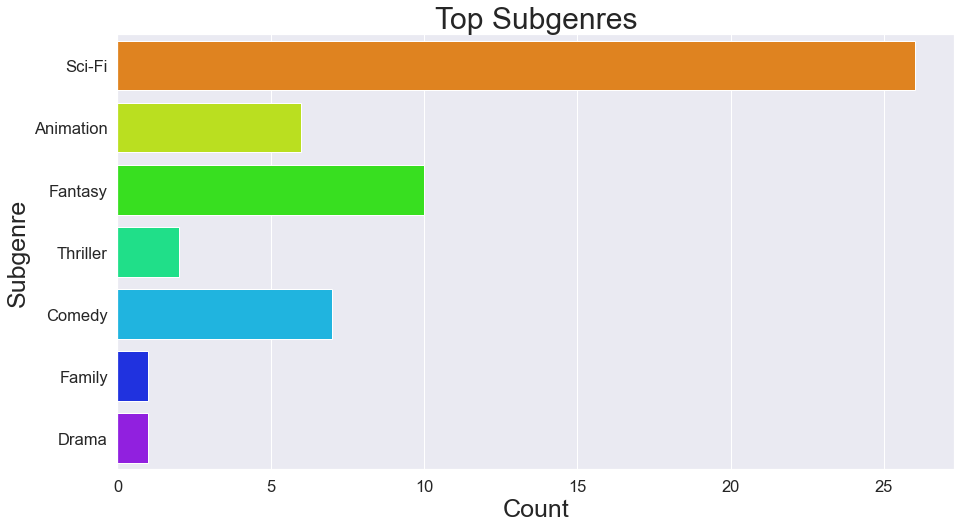

In [75]:
# Create a plot and set the size.
plt.figure(figsize=(15,8))

# Increase the size of the scale text.
sns.set(font_scale=1.5)

# Plot the data
sns.barplot(y=list(all_subgenres.keys()),
            x=list(all_subgenres.values()), palette='gist_rainbow')

# Set the barplot's title.
plt.title('Top Subgenres', fontsize=30)

# Label the y-axis
plt.ylabel('Subgenre', fontsize=25)

# Label the x-axis
plt.xlabel('Count', fontsize=25);

Sci-Fi is by far the most popular subgenre.  Let's see how these subgenres stack up with `production_budget`.

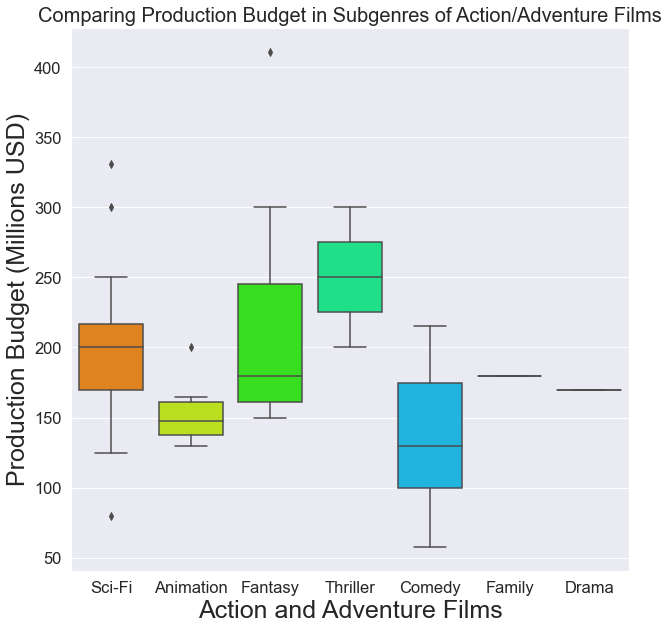

In [76]:
# Create a plot and set the size.
plt.figure(figsize=(10,10))

# Increase the size of the scale text.
sns.set(font_scale=1.5)

# Plot the data
sns.boxplot(x=top_aa_movies['genres'],
            y=top_aa_movies['production_budget']/1000000, palette='gist_rainbow')

# Set the barplot's title.
plt.title('Comparing Production Budget in Subgenres of Action/Adventure Films', fontsize=20)

# Label the y-axis
plt.ylabel('Production Budget (Millions USD)', fontsize=25)

# Label the x-axis
plt.xlabel('Action and Adventure Films', fontsize=25);

Let's do the same comparison with the ***Return on Investment***

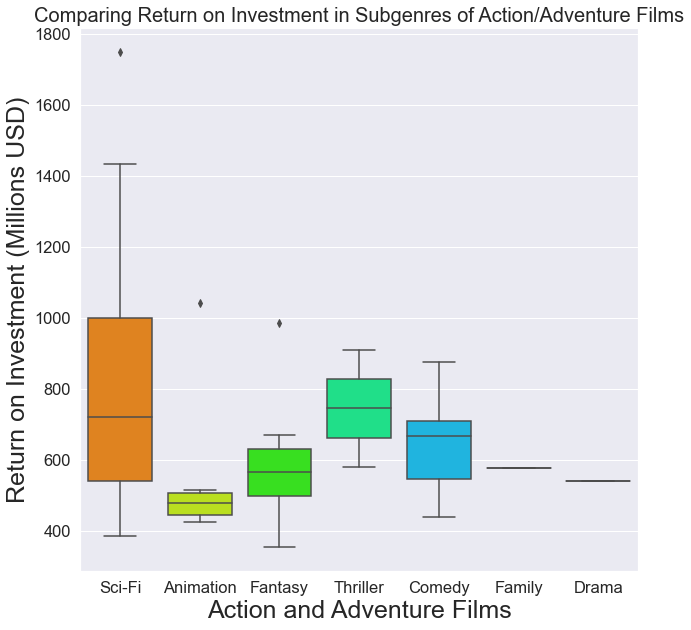

In [77]:
# Create a plot and set the size.
plt.figure(figsize=(10,10))

# Increase the size of the scale text.
sns.set(font_scale=1.5)

# Plot the data
sns.boxplot(x=top_aa_movies['genres'],
            y=top_aa_movies['return_on_investment']/1000000, palette='gist_rainbow')

# Set the barplot's title.
plt.title('Comparing Return on Investment in Subgenres of Action/Adventure Films', fontsize=20)

# Label the y-axis
plt.ylabel('Return on Investment (Millions USD)', fontsize=25)

# Label the x-axis
plt.xlabel('Action and Adventure Films', fontsize=25);

#### Top sub-genre summary

***Action, Adventure, Sci-Fi*** is the most popular sub-genre among the top grossing films.  

This sub-genre has a median return on investment of ***$720 million***


### Runtime

#### Top 100 Movies

Now that we have an idea how of how the `genre` affects `production_budget`, `domestic_gross`, and `return_on_investment`, let's move onto runtime.

Let see if there is any correlation between `runtime` and `return_on_investment`.

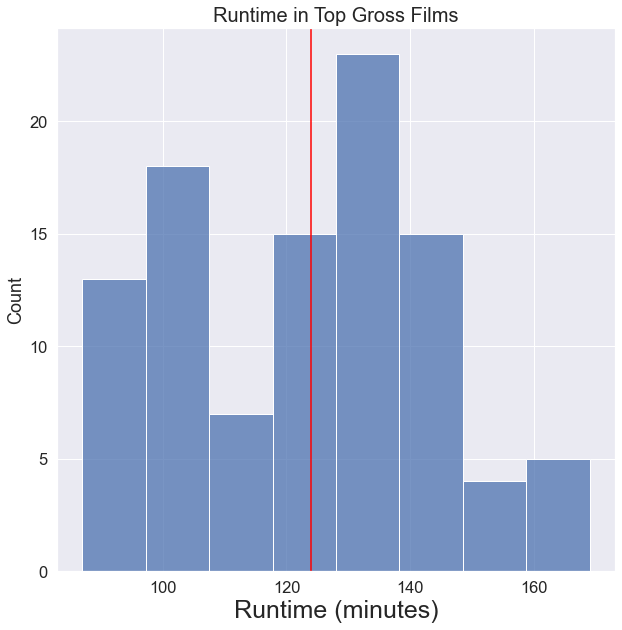

In [90]:
# Create a plot and set the size.
plt.figure(figsize=(10,10))

# Increase the size of the scale text.
sns.set(font_scale=1.5)

# Plot the data
sns.histplot(top_100_movies['runtime_minutes'])

# Create a vertical line at the 
plt.axvline(x = top_100_movies['runtime_minutes'].median(), color = 'red', label = 'Average Runtime')

# Set the barplot's title.
plt.title('Runtime in Top Gross Films', fontsize=20)

# Label the x-axis
plt.xlabel('Runtime (minutes)', fontsize=25);

In [79]:
# Prints out the average runtime for the Top 100 Films
print('Average runtime is {}'.format(top_100_movies['runtime_minutes'].median()))

Average runtime is 124.0


We can see the the majority of films have a runtime between ***120 and 150 minutes*** and a `median` value of ***124 minutes***.

Let's see if runtime has any affect on `worldwide_gross`

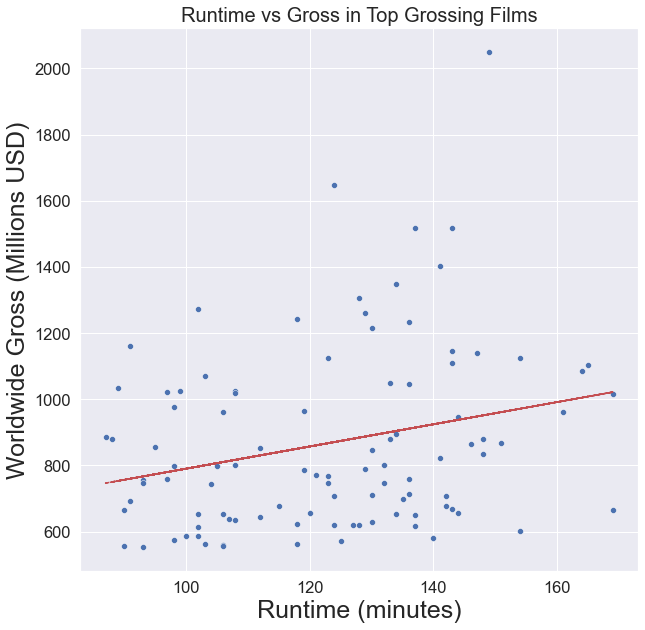

In [91]:
# Create a plot and set the size.
plt.figure(figsize=(10,10))

# Increase the size of the scale text.
sns.set(font_scale=1.5)

# Plot the data
sns.scatterplot(x=top_100_movies['runtime_minutes'],
            y=top_100_movies['worldwide_gross']/1000000)

# Create a trendline 
z = np.polyfit(top_100_movies['runtime_minutes'], top_100_movies['worldwide_gross']/1000000, 1)
p = np.poly1d(z)
plt.plot(top_100_movies['runtime_minutes'],p(top_100_movies['runtime_minutes']),"r--")

# Set the barplot's title.
plt.title('Runtime vs Gross in Top Grossing Films', fontsize=20)

# Label the y-axis
plt.ylabel('Worldwide Gross (Millions USD)', fontsize=25)

# Label the x-axis
plt.xlabel('Runtime (minutes)', fontsize=25);

Now that we see the trend line, let's calculate the correlation.

In [81]:
# Calls numpy correlation and set it equal to "correlation_matrix"
correlation_matrix = np.corrcoef(top_100_movies['runtime_minutes'], top_100_movies['worldwide_gross'])

# Let's view the correlation and round it to 2 decimal points
correlation_matrix[0][1].round(2)

0.25

This shows a weak positive correlation.  This could be coicidental or due to the fact that longer movies tend to have larger production budgets and thus a correlation with gross.  Let's check the correlation between ***Production Budget*** and ***Worldwide Gross***

In [82]:
# Calls numpy correlation and set it equal to "correlation_matrix"
correlation_matrix = np.corrcoef(top_100_movies['production_budget'], top_100_movies['worldwide_gross'])

# Let's view the correlation and round it to 2 decimal points
correlation_matrix[0][1].round(2)

0.38

This time we see a slightly stronger positive correlation. Finally let's compare ***Production Budget*** and ***Runtime***

In [83]:
# Calls numpy correlation and set it equal to "correlation_matrix"
correlation_matrix = np.corrcoef(top_100_movies['production_budget'], top_100_movies['runtime_minutes'])

# Let's view the correlation and round it to 2 decimal points
correlation_matrix[0][1].round(2)

0.4

This is the strongest positive correlation of the three.

#### Action and Adventure Films

Let's do that same analysis for ***Action*** and ***Adventure*** films.

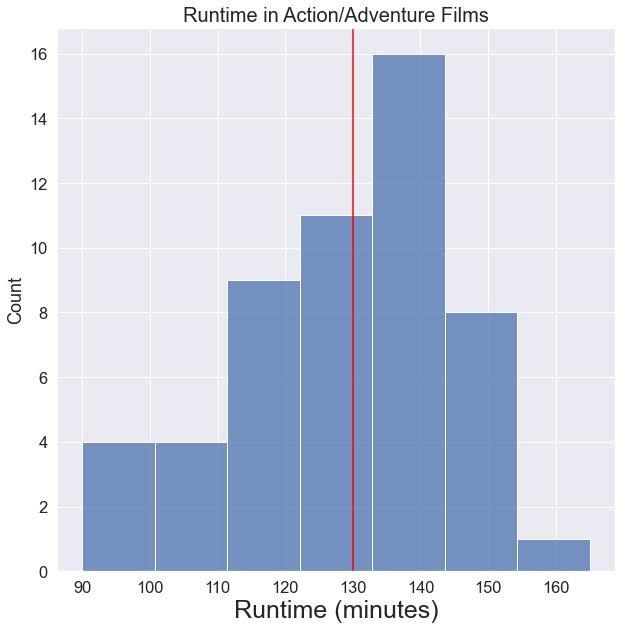

In [92]:
# Create a plot and set the size.
plt.figure(figsize=(10,10))

# Increase the size of the scale text.
sns.set(font_scale=1.5)

# Plot the data
sns.histplot(top_aa_movies['runtime_minutes'])

# Create a vertical line at the 
plt.axvline(x = top_aa_movies['runtime_minutes'].median(), color = 'red', label = 'Average Runtime')

# Set the barplot's title.
plt.title('Runtime in Action/Adventure Films', fontsize=20)

# Label the x-axis
plt.xlabel('Runtime (minutes)', fontsize=25);

The ***120 to 150 minute*** trend is even more prominant in Action/Adventure films.

In [85]:
# Prints out the average runtime for the Top 100 Films
print('Average runtime is {}'.format(top_aa_movies['runtime_minutes'].median()))

Average runtime is 130.0


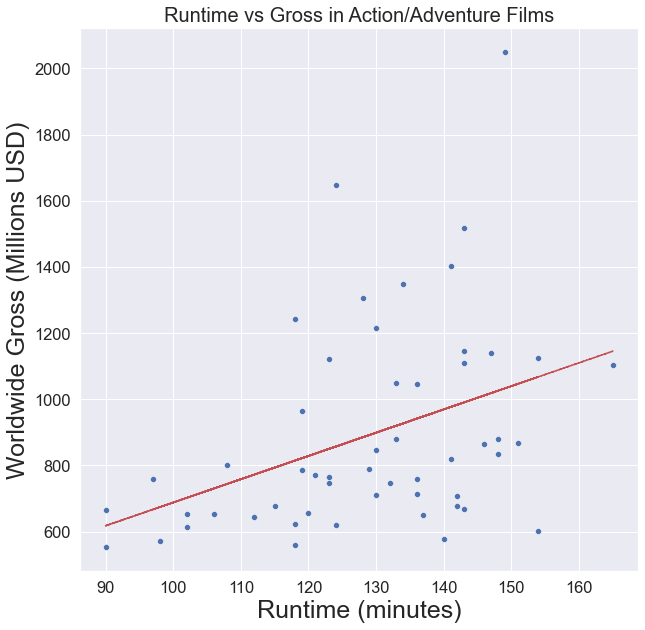

In [93]:
# Create a plot and set the size.
plt.figure(figsize=(10,10))

# Increase the size of the scale text.
sns.set(font_scale=1.5)

# Plot the data
sns.scatterplot(x=top_aa_movies['runtime_minutes'],
            y=top_aa_movies['worldwide_gross']/1000000)

# Create a trendline 
z = np.polyfit(top_aa_movies['runtime_minutes'], top_aa_movies['worldwide_gross']/1000000, 1)
p = np.poly1d(z)
plt.plot(top_aa_movies['runtime_minutes'],p(top_aa_movies['runtime_minutes']),"r--")

# Set the barplot's title.
plt.title('Runtime vs Gross in Action/Adventure Films', fontsize=20)

# Label the y-axis
plt.ylabel('Worldwide Gross (Millions USD)', fontsize=25)

# Label the x-axis
plt.xlabel('Runtime (minutes)', fontsize=25);

In [94]:
# Calls numpy correlation and set it equal to "correlation_matrix"
correlation_matrix = np.corrcoef(top_aa_movies['runtime_minutes'], top_aa_movies['worldwide_gross'])

# Let's view the correlation and round it to 2 decimal points
correlation_matrix[0][1].round(2)

0.39

In [95]:
# Calls numpy correlation and set it equal to "correlation_matrix"
correlation_matrix = np.corrcoef(top_aa_movies['production_budget'], top_aa_movies['worldwide_gross'])

# Let's view the correlation and round it to 2 decimal points
correlation_matrix[0][1].round(2)

0.42

In [96]:
# Calls numpy correlation and set it equal to "correlation_matrix"
correlation_matrix = np.corrcoef(top_aa_movies['production_budget'], top_aa_movies['runtime_minutes'])

# Let's view the correlation and round it to 2 decimal points
correlation_matrix[0][1].round(2)

0.39

We can see that `runtime` does not correlate `return_on_investment`, but we can see that films that are in our range of ***120 to 150 minutes*** tend to a little better.

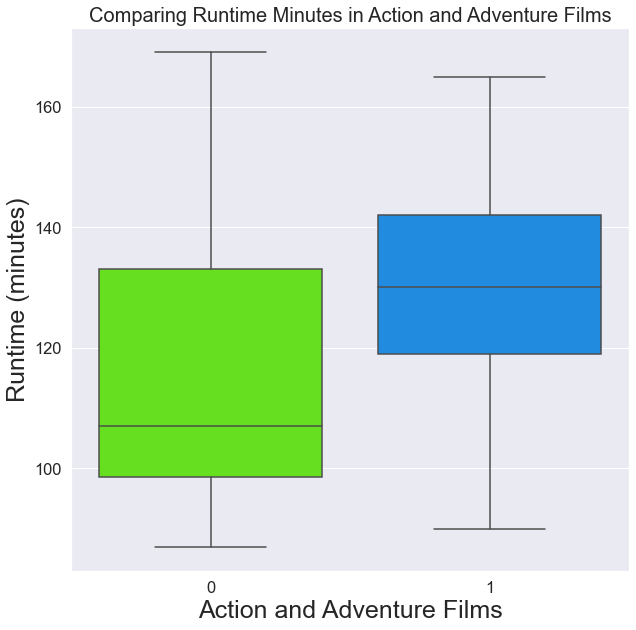

In [97]:
# Create a plot and set the size.
plt.figure(figsize=(10,10))

# Increase the size of the scale text.
sns.set(font_scale=1.5)

# Plot the data
sns.boxplot(x=top_100_movies['action_and_adventure'],
            y=top_100_movies['runtime_minutes'], palette='gist_rainbow')

# Set the barplot's title.
plt.title('Comparing Runtime Minutes in Action and Adventure Films', fontsize=20)

# Label the y-axis
plt.ylabel('Runtime (minutes)', fontsize=25)

# Label the x-axis
plt.xlabel('Action and Adventure Films', fontsize=25);

Action and Adventure films have a `median` runtime of ***130 minutes*** while non-Action and Adventure films are closer to ***110 minutes***

#### Runtime Summary

Most top grossing movies fall into the ***120 to 150 minute*** range with an average of ***127 minutes***.  

## Conclusions

Through our data analysis we were able to determine some key information that Microsoft can use in the creation of their new film studio.  

#### Make an Action or Adventureb film
Action/Adventure movies had an average ***Return on Investment*** or ***$703 million*** and the two most popular genres among the top grossing movies.

#### More Specifically, make an Action, Adventure, Sci-Fi movie
This sub-genre of Action/Adventure accounts for nearly is most popular in the category.  It has an average Porduction Budget of ***$200 million*** and an average return on investment of over ***$700 million***

#### Top grossing movies are roughly 2 hours long
The average runtime for top grossing movies is ***127 minutes*** and most falling between ***120 to 150 minutes***.
Action/Adventure movies mostly fall into this range with other genres being shorter.

This is only a glimpse into what has been successful in the film industry in recent year. More information can be obtained by researching both the directors and actors within each genre.  We can also see the success of different writers with those genres.  Release date can make a differnce depending on which genres you decide to go with and what you intentions for the films are.

In [98]:
top_100_movies.to_csv('Data/top_100_movies.csv')

In [99]:
top_aa_movies.to_csv('Data/top_aa_movies.csv')